OPENING OF BANDS WITH RASTERIO

In [1]:
import rasterio as rio
BANDS='S2B_MSIL2A_20220103T101319_N0301_R022_T30NZM_20220103T130628.SAFE\GRANULE\L2A_T30NZM_A025216_20220103T101650\IMG_DATA\R10m'
B4_RED=rio.open(BANDS+'/T30NZM_20220103T101319_B04_10m.jp2')
B8_NIR=rio.open(BANDS+'/T30NZM_20220103T101319_B08_10m.jp2')

RR10='Rayleigh_Corrected'
B04_RED=rio.open(RR10+'/S2B_MSIL1C_20220103T101319_N0301_R022_T30NZM_20220103T121450_rayleigh_REDD.tif')
B08_NIR=rio.open(RR10+'/S2B_MSIL1C_20220103T101319_N0301_R022_T30NZM_20220103T121450_rayleigh_NIRR.tif')
B11_SWIR=rio.open(RR10+'/S2B_MSIL1C_20220103T101319_N0301_R022_T30NZM_20220103T121450_rayleigh_SWIR.tif')


COMPUTATION OF NDVI AND STORING IN A TIF file

In [2]:
import numpy
numpy.seterr(divide='ignore',invalid='ignore')
RED=B4_RED.read()
NIR=B8_NIR.read()

NDVI=(NIR.astype(float)-RED.astype(float))/(NIR+RED)


meta=B4_RED.meta
print(meta)
NDVI_type=NDVI.dtype
print(NDVI_type)

kwargs=meta

kwargs.update(dtype=NDVI_type)
kwargs.update(count=1)
kwargs.update(driver='GTiff')

with rio.open('NDVI_data/NDVI.tif','w',**kwargs) as dst:
    dst.write(NDVI)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 799980.0,
       0.0, -10.0, 700020.0)}
float64


Opening Shapefile


In [3]:
import geopandas as gpd
nReserve=gpd.read_file('shapefile/Kpong_Reservoir-polygon.shp')

Using shapefile to clip the data to have only the water body and storing the new data.

In [4]:
from rasterio.mask import mask
nReserve_proj=nReserve.to_crs('epsg:32630')

with rio.open("NDVI_data/NDVI.tif") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open("NDVI_data/NDVI_masked.tif","w",**out_meta) as dest:
    dest.write(out_image)

Opening and reading the clipped earth observation data

In [5]:
image_file="NDVI_data/NDVI_masked.tif"
NDVII=rio.open(image_file)
NDVIRI=NDVII.read()

Class written by Joe Kington to Normalize the colorbar.

In [6]:
from matplotlib import colors

# Credit: Joe Kington
class MidpointNormalize(colors.Normalize):
    """
    Normalize the colorbar so that diverging bars work there way either side from a prescribed midpoint value
    
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

Attaining the colormap plot

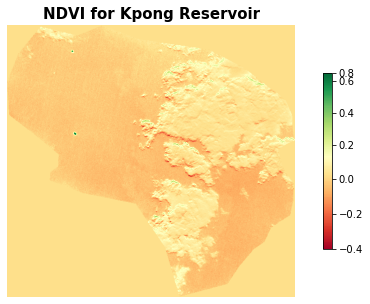

In [7]:
import matplotlib.pyplot as plt

min=numpy.nanmin(NDVIRI)
max=numpy.nanmax(NDVIRI)

mid=0.1
colormap=plt.cm.RdYlGn
norm= MidpointNormalize(vmin=min,vmax=max,midpoint=mid)
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
NDVIRI=NDVIRI.squeeze()
cbar_plot=ax.imshow(NDVIRI, cmap=colormap, norm=norm)
ax.axis('off')
cbar=fig.colorbar(cbar_plot,orientation='vertical',shrink=0.65)
ax.set_title('NDVI for Kpong Reservoir',fontsize=15,fontweight='bold')
fig.savefig("NDVI_data/ndvi-fig",dpi=200,bbox_inches='tight',pad_inches=0.7)


Attaining the Histogram Plot

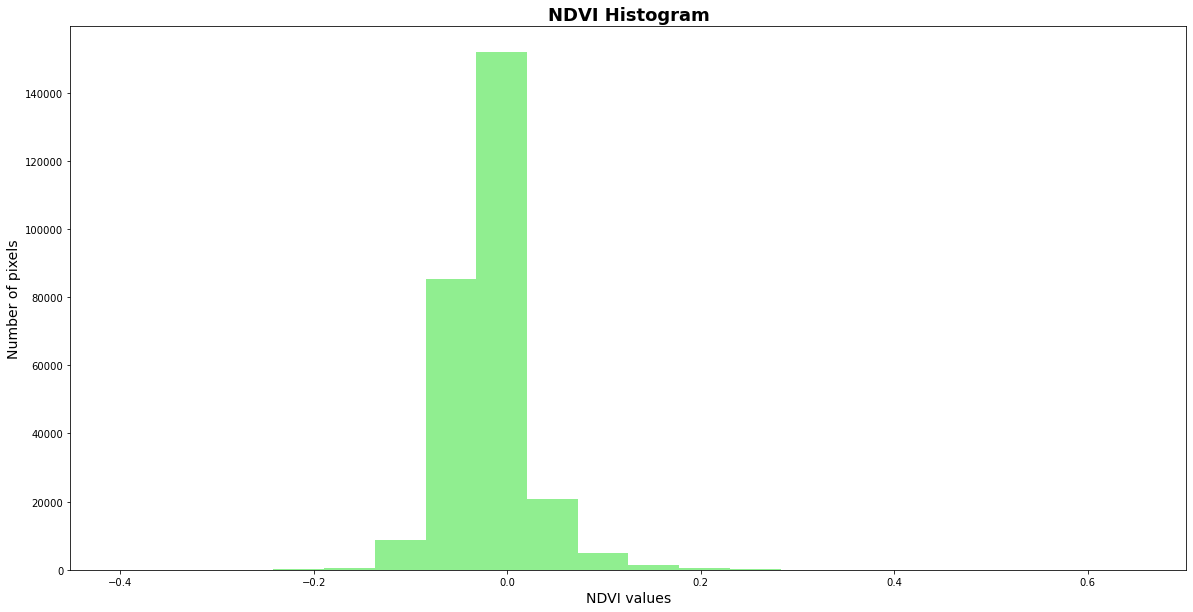

In [8]:
fig2 = plt.figure(figsize=(20,10))
ax = fig2.add_subplot(111)
plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("Number of pixels", fontsize=14)
x = NDVIRI[~numpy.isnan(NDVIRI)]
bins = 20
color = 'lightgreen'
ax.hist(x,bins,color=color)
fig2.savefig("NDVI_data/ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

In [9]:
fig.savefig(r"C:\xampp\htdocs\SourceCode/ndvi-fig_20220103T101319.png", dpi=200,bbox_inches='tight',pad_inches=0.7)
fig2.savefig(r"C:\xampp\htdocs\SourceCode/ndvi-histogram_20220103T101319.png",dpi=200,bbox_inches='tight',pad_inches=0.7)

Central Wavelength of Red,Near-Infrared & Shortwave Infrared  Bands

In [10]:
WRED=665
WNIR=842
WSWIR=1610

COMPUTATION OF FAI AND STORING IN A TIF file

In [11]:
RED=B04_RED.read()
NIR=B08_NIR.read()
SWIR=B11_SWIR.read()

FAI=(NIR-RED)+((SWIR-RED)*((WNIR-WRED)/(WSWIR-WRED)))

metta=B04_RED.meta
print(metta)
FAI_type=FAI.dtype
# print(FAI_type)

kwargss=metta

kwargss.update(dtype=FAI_type)
# kwargss.update(count=1)
kwargss.update(driver='GTiff')

with rio.open('FAI_data/FAI.tif','w',**kwargss) as dstt:
    dstt.write(FAI)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 5, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 799980.0,
       0.0, -10.0, 700020.0)}


Using shapefile to clip the data to have only the water body and storing the new data.

In [12]:
with rio.open("FAI_data/FAI.tif") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open("FAI_data/FAI_masked.tif","w",**out_meta) as dest:
    dest.write(out_image) 

Opening and reading the clipped earth observation data

In [13]:
image_file="FAI_data/FAI_masked.tif"
FAII=rio.open(image_file)
FAIRI=FAII.read(1)

Attaining colormap plot

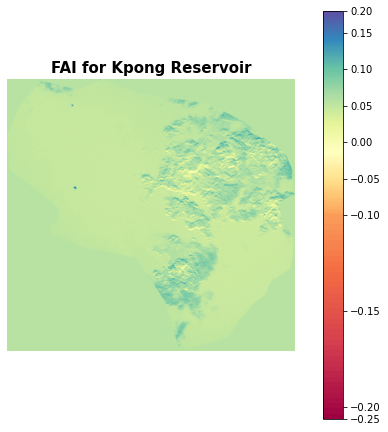

In [14]:
min=numpy.nanmin(FAIRI)
max=numpy.nanmax(FAIRI)
mid=-0.1

colormap=plt.cm.Spectral
norm= MidpointNormalize(vmin=min,vmax=max,midpoint=mid)
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
# FAIRI=FAIRI.squeeze()
cbar_plot=ax.imshow(FAIRI, cmap=colormap, norm=norm)
ax.axis('off')
cbar=fig.colorbar(cbar_plot,orientation='vertical',shrink=1.5)
ax.set_title('FAI for Kpong Reservoir',fontsize=15,fontweight='bold')
fig.savefig("FAI_data/fai-fig",dpi=200,bbox_inches='tight',pad_inches=0.7)

Attaining Histogram Plot

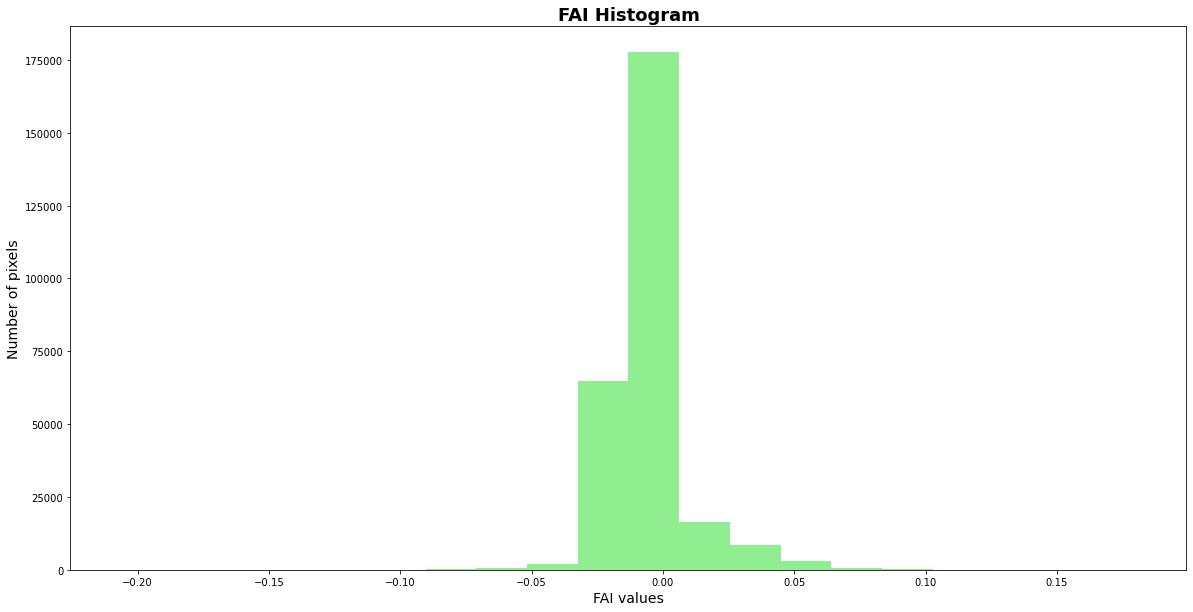

In [15]:
fig2 = plt.figure(figsize=(20,10))
ax = fig2.add_subplot(111)
plt.title("FAI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("FAI values", fontsize=14)
plt.ylabel("Number of pixels", fontsize=14)
x = FAIRI[~numpy.isnan(FAIRI)]
bins = 20
color = 'lightgreen'
ax.hist(x,bins,color=color)
fig2.savefig("FAI_data/fai-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

In [16]:
fig.savefig(r"C:\xampp\htdocs\SourceCode/fai-fig_20220103T101319.png", dpi=200,bbox_inches='tight',pad_inches=0.7)
fig2.savefig(r"C:\xampp\htdocs\SourceCode/fai-histogram_20220103T101319.png",dpi=200,bbox_inches='tight',pad_inches=0.7)

Forwarding all the Information to the Database

In [17]:
import mysql.connector
from mysql.connector import Error


In [18]:
x=0
try:
    connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')

    
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)
        x=x+1

except Error as e:
    print("Error while connecting to MySQL", e)


Connected to MySQL Server version  5.5.5-10.4.22-MariaDB
You're connected to database:  ('remotesensingdata',)


In [19]:
MinNDVI=float(numpy.nanmin(NDVIRI))
MaxNDVI=float(numpy.nanmax(NDVIRI))
MeanNDVI=float(numpy.nanmean(NDVIRI))
StdNDVI=float(numpy.std(NDVIRI))
MinFAI=float(numpy.nanmin(FAIRI))
MaxFAI=float(numpy.nanmax(FAIRI))
MeanFAI=float(numpy.nanmean(FAIRI))
StdFAI=float(numpy.std(FAIRI))
Id='20220103T101319'


In [20]:
connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')

cursor=connection.cursor()
cursor.execute("INSERT INTO presenceofhab (DatasetID, NDVIMean, NDVIMax, NDVIMin, NDVIStandardDeviation, FAIMean, FAIMax, FAIMin, FAIStandardDeviation) VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s)", (Id,MeanNDVI,MaxNDVI,MinNDVI,StdNDVI,MeanFAI,MaxFAI,MinFAI,StdFAI))
connection.commit()
print(cursor.rowcount,"Record insert successfully in to Table")

cursor.close()

1 Record insert successfully in to Table


True

In [21]:
FAIfigure='FAI_data/fai-fig.png'
FAIHistogram='FAI_data/fai-histogram.png'
NDVIfigure='NDVI_data/ndvi-fig.png'
NDVIHistogram='NDVI_data/ndvi-histogram.png'
Id='20220103T101319'
FAIHistName='fai-histogram_20220103T101319.png'
FAIFigName='fai-fig_20220103T101319.png'
NDVIHistName='ndvi-histogram_20220103T101319.png'
NDVIFigName='ndvi-fig_20220103T101319.png'

In [22]:
import mysql.connector
connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')

def convertToBinaryData(filename):
    with open(filename,'rb') as file:
        binaryData=file.read()
    return binaryData

In [23]:
def INSERTPIC(ID,FIG,HIST,FIGONE,HISTONE,FIGN,HISTN,FIGF,HISTF):
    connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')
    C=connection.cursor()
    
    Figpic=convertToBinaryData(FIG)
    Histpic=convertToBinaryData(HIST)
    Figpic1=convertToBinaryData(FIGONE)
    Histpic1=convertToBinaryData(HISTONE)
    
    C.execute("INSERT INTO habimages (DatasetID,FAIfig,FAIHistogram,NDVIfig,NDVIHistogram,NDVIFigName,NDVIHistName,FAIFigName,FAIHistName) VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s)",(ID,Figpic,Histpic,Figpic1,Histpic1,FIGN,HISTN,FIGF,HISTF))
    
    connection.commit()
    print(C.rowcount,"Record insert successfully in to Table")

In [28]:
INSERTPIC(Id,FAIfigure,FAIHistogram,NDVIfigure,NDVIfigure,NDVIFigName,NDVIHistName,FAIFigName,FAIHistName)


1 Record insert successfully in to Table
